# Reading SOCAT data with xarray

This downloads data from [figshare](https://figshare.com/s/bf4e0963bc04c410771d), extracts the data with [xarray](http://xarray.pydata.org/en/stable/), and plots it with [cartopy](https://scitools.org.uk/cartopy/docs/v0.16/)

### Notes
Think about how you want to organize the project in this github repo. Here is a scheme I tend to use. Maybe it's not the best scheme for this project. You will have less headaches down the road if you think of an organization scheme at the very beginning and stick with it. 
* `data` = place to store data. Can be separated into `data/raw` and `data/clean`
* `doc` = documentation and maybe a list of references 
* `model` = model code
* `notebooks` = jupyter notebooks to generate figures
* `results` = project results. I break it down into `results/figures` and `results/papers`
* `scripts` = analysis scripts. this is where I put scripts to process raw data
* `scratch` = This is junk that could be deleted, but maybe I will regret deleting it. 

## Download data from figshare
either use `wget` or `curl`. Uncomment the one you want to use. This will download the file (~1.5 Gb) to the current directory

**>>>> Make sure you change the output path!! <<<<<**

In [1]:
### Download data with wget
#!wget https://ndownloader.figshare.com/files/13189430?private_link=bf4e0963bc04c410771d -O /Users/gloege/Documents/Projects/ocean-co2-absorption/data/SOCATv5_gridded_monthly.nc

### Download data with curl
!curl https://ndownloader.figshare.com/files/13189430?private_link=bf4e0963bc04c410771d --output /Users/gloege/Desktop/SOCATv5_gridded_monthly.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 64 1396M   64  902M    0     0  14.4M      0  0:01:36  0:01:02  0:00:34 15.0M^C


## import modules
* `xarray` is used to read netcdf files
* `cartopy` is the package I use to plot geospatial data

In [1]:
%matplotlib inline

### for reading .nc files
import xarray as xr
import numpy as np

### a nice set of colormaps designed to be used for oceangraphic data
### and optimized for colorblindness and contrast if printed in black and white
import cmocean as cm

import matplotlib as mpl
import matplotlib.pyplot as plt

### for making nice geospatial plots (because plt.pcolormesh() is pretty shitty)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# define directories
I like to define common directories at the top. Then I move notebooks between machines all I need to do is change these paths

Within my `data_dir` sometimes I will have `data/raw` for un-processed and `data/clean` for processed data. 
I also usually have `fig_dir` to save figures to a commmon location

In [2]:
data_dir = '/Users/cg/co2/'

# class to make spatial maps
This is a class I wrote to plot spatial data so I do not have to keep typing the same thing over and over. 

Feel free to change this. It's not perfect and can be improved

In [3]:
class SpatialMap(object):
    """
    Spatial Map
    Plot data on a world map centerted at 157.5 deg
    * set_ticks
    * set_title
    * set_cbar_title
    """

    def __init__(self, data, lon=np.arange(0.5,360,1), lat=np.arange(-89.5,90,1), 
                 fig=None, rect=111, vrange = [0, 1],  
                 cmap=cm.cm.balance, 
                 colorbar=True, ncolors=101):
        ''' spatial_map()'''
    
        ### Setup figure and axes
        if fig is None:
            fig = plt.figure(figsize=(8.5,11))
        
        ### Setup axes
        self.ax = fig.add_subplot(rect, projection=ccrs.Robinson(central_longitude=-157.5))
        fig.add_subplot(self.ax)
        
        ### Latitude and longitude
        #self.lon=np.arange(0.5,360,1)
        #self.lat=np.arange(-89.5,90,1)
        
        #self.lon=ds['xlon']
        #self.lat=ds['ylat']
        self.lon = lon
        self.lat = lat
        
        ### colorbar
        self.transform = ccrs.PlateCarree(central_longitude=0)
        self.bounds = np.linspace(vrange[0], vrange[1], ncolors)
        self.norm = mpl.colors.BoundaryNorm(self.bounds, cmap.N)
        
        ### land mask
        self.ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                    edgecolor='face', 
                                                    facecolor=[0.4, 0.4, 0.4]))
        self.ax.coastlines(facecolor=[0.4, 0.4, 0.4])
        
        ### Add data to map
        sub = self.ax.pcolormesh(self.lon, self.lat, data,
                                    norm=self.norm,
                                    transform=self.transform,
                                    cmap = cmap,
                                    vmin = vrange[0],
                                    vmax = vrange[1])

        ### Colorbar
        if colorbar is True:
            self.cbar = plt.colorbar(sub, orientation="horizontal", pad=0.01, shrink=0.8)
            self.cbar.ax.tick_params(labelsize=14)
    
    ### Class methods
    def set_ticks(self, tmin, tmax, dt, *args, **kwargs):
        self.cbar.set_ticks(np.arange(tmin, tmax+dt, dt))
        
    def set_title(self, title, *args, **kwargs):
        self.ax.set_title(title, fontsize=16, **kwargs)
        
    def set_cbar_title(self, title, *args, **kwargs):
        self.cbar.set_label(title,fontsize=16)

## Load dataset

This loads the dataset. just like `df` is the standard variable name for a pandas dataframe, `ds` is the standard name for dataset in xarray

You can can get a terse overview of the data by typing the variable name. in this vase `ds`

ocean pCO2 is contained in the variable name `FCO2_AVE_UNWTD`

In [4]:
ds = xr.open_dataset(f'{data_dir}SOCATv5_gridded_monthly.nc')
ds

<xarray.Dataset>
Dimensions:            (bnds: 2, tmnth: 565, xlon: 360, ylat: 180)
Coordinates:
  * xlon               (xlon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat               (ylat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * tmnth              (tmnth) datetime64[ns] 1970-01-16T12:00:00 ... 2017-01-16T12:00:00
Dimensions without coordinates: bnds
Data variables:
    Note               |S26 ...
    tmnth_bnds         (tmnth, bnds) float64 ...
    count_ncruise      (tmnth, ylat, xlon) float32 ...
    count_nobs         (tmnth, ylat, xlon) float32 ...
    FCO2_AVE_WEIGHTED  (tmnth, ylat, xlon) float32 ...
    FCO2_AVE_UNWTD     (tmnth, ylat, xlon) float32 ...
    fco2_min_unwtd     (tmnth, ylat, xlon) float32 ...
    fco2_max_unwtd     (tmnth, ylat, xlon) float32 ...
    fco2_std_weighted  (tmnth, ylat, xlon) float32 ...
    fco2_std_unwtd     (tmnth, ylat, xlon) float32 ...
    lat_offset_unwtd   (tmnth, ylat, xlon) float32 ...
    lon_offset_unwtd  

In [5]:
### You can see the meta data with the info() method
ds.info()

xarray.Dataset {
dimensions:
	bnds = 2 ;
	tmnth = 565 ;
	xlon = 360 ;
	ylat = 180 ;

variables:
	|S26 Note() ;
		Note:long_name = "SOCAT gridded v5  5-Jun-17" ;
		Note:history = From /home/data/socat/v5/SOCAT_tracks_gridded_monthly_v5.nc ;
	float64 xlon(xlon) ;
		xlon:units = degrees_east ;
		xlon:point_spacing = even ;
		xlon:axis = X ;
		xlon:modulo = 360.0 ;
		xlon:standard_name = longitude ;
	float64 ylat(ylat) ;
		ylat:units = degrees_north ;
		ylat:point_spacing = even ;
		ylat:axis = Y ;
		ylat:standard_name = latitude ;
	datetime64[ns] tmnth(tmnth) ;
		tmnth:axis = T ;
		tmnth:bounds = tmnth_bnds ;
		tmnth:time_origin = 1-JAN-1970 ;
		tmnth:standard_name = time ;
	float64 tmnth_bnds(tmnth, bnds) ;
	float32 count_ncruise(tmnth, ylat, xlon) ;
		count_ncruise:long_name = Number of cruises ;
		count_ncruise:units = count ;
		count_ncruise:history = From /home/data/socat/v5/SOCAT_triples_v5_fco2.nc ;
		count_ncruise:summary = Number of datasets containing observations in the grid ce

## Extract variables from dataset

I never use lon or lat...

In [6]:
lon = ds['xlon']
lat = ds['ylat']
pco2 = ds['FCO2_AVE_UNWTD']

# Let's look at some statistics

the max is 4118.472168 uatm. That's pretty damn high and I don't believe it. I would set something that ignores stuff greater than 600 or so. SOCAT has an automated quality control so maybe they throw away a few good data points and keep a couple bad ones. But remember, they have millions of data points in the raw un-gridded product, so throwing out a few points isn't the end of the world, but keeping a couple bad ones meand we have to do our own quality control.

In [7]:
print(f'Shape of pco2 is --> {pco2.shape}')
print(f'MIN pco2 = {np.min(pco2)}')
print(f'MAX pco2 = {np.max(pco2)}')

Shape of pco2 is --> (565, 180, 360)
MIN pco2 = <xarray.DataArray 'FCO2_AVE_UNWTD' ()>
array(69.54724, dtype=float32)
MAX pco2 = <xarray.DataArray 'FCO2_AVE_UNWTD' ()>
array(4118.472, dtype=float32)


# Make some plots with xarray

## 1. Mean over time

/Users/cg/anaconda3/envs/capstone_CO2/lib/python3.7/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


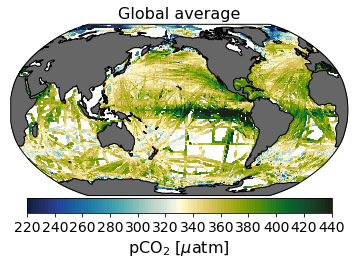

In [8]:
### calcualtes mean of time (tmnth is the time variable in SOCAT)
data = pco2.mean('tmnth')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds['xlon'], lat=ds['ylat'], fig=fig, rect=122, vrange=[220, 440], cmap=cm.cm.delta)
worldmap.set_ticks(220,440,20)
worldmap.set_cbar_title('pCO$_2$ [$\mu$atm]')
worldmap.set_title('Global average')

## 2. Mean across specified month

/Users/cg/anaconda3/envs/capstone_CO2/lib/python3.7/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


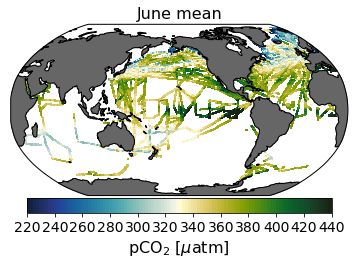

In [9]:
data = pco2.where(ds['tmnth.month']==6).mean('tmnth')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds['xlon'], lat=ds['ylat'], fig=fig, rect=122, vrange=[220, 440], cmap=cm.cm.delta)
worldmap.set_ticks(220,440,20)
worldmap.set_cbar_title('pCO$_2$ [$\mu$atm]')
worldmap.set_title('June mean')

## 3. Plot specific month and year

/Users/cg/anaconda3/envs/capstone_CO2/lib/python3.7/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


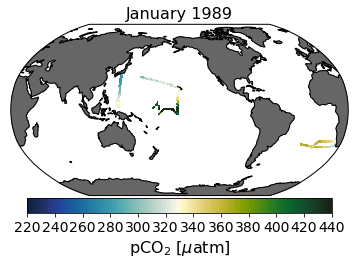

In [10]:
data = pco2.where((ds['tmnth.month']==1) & 
                          (ds['tmnth.year']==1989)).mean('tmnth')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds['xlon'], lat=ds['ylat'], fig=fig, rect=122, vrange=[220, 440], cmap=cm.cm.delta)
worldmap.set_ticks(220,440,20)
worldmap.set_cbar_title('pCO$_2$ [$\mu$atm]')
worldmap.set_title('January 1989')

## 4. Only plot southern hemisphere

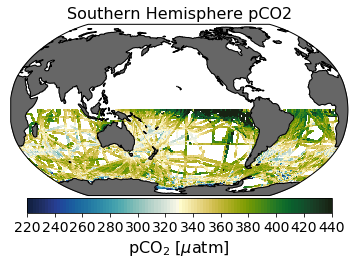

In [11]:
data = pco2.where(ds['ylat']<=0).mean('tmnth')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds['xlon'], lat=ds['ylat'], fig=fig, rect=122, vrange=[220, 440], cmap=cm.cm.delta)
worldmap.set_ticks(220,440,20)
worldmap.set_cbar_title('pCO$_2$ [$\mu$atm]')
worldmap.set_title('Southern Hemisphere pCO2')

## 5. North Atlantic

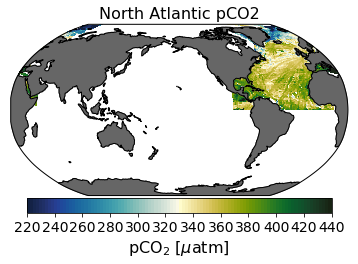

In [12]:
data = pco2.where((ds['ylat']>=0) & (ds['xlon']<=50) & (ds['xlon']>=-100)).mean('tmnth')

fig = plt.figure(figsize=(15,15*0.25))
worldmap = SpatialMap(data, lon=ds['xlon'], lat=ds['ylat'], fig=fig, rect=122, vrange=[220, 440], cmap=cm.cm.delta)
worldmap.set_ticks(220,440,20)
worldmap.set_cbar_title('pCO$_2$ [$\mu$atm]')
worldmap.set_title('North Atlantic pCO2')